In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel, mannwhitneyu, shapiro, ttest_ind

In [2]:
# Import the data
df = pd.read_csv(r'C:\Users\Lindsay\Github\MEA_data\Before Hypoxia Plate 4(001)(000)_spike_counts.csv')

In [3]:
# Deleting empty columns
df = df.dropna(axis=1, how='all')

# deleting the unnamed column
df = df.drop('Unnamed: 2', axis=1)

df.head()

,Interval Start (S),Interval End (S),A1,A1_11,A1_12,A1_13,A1_14,A1_15,A1_16,A1_17,...,A1_77,A1_78,A1_81,A1_82,A1_83,A1_84,A1_85,A1_86,A1_87,A1_88
0,00000.000000,00001.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00001.000000,00002.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00002.000000,00003.000000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00003.000000,00004.000000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00004.000000,00005.000000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The highlighted text is a line of Python code that uses the `dropna` method from the pandas library to remove columns from a DataFrame (`df`) that contain only `NaN` (Not a Number) values.

Explanation:
`df.dropna(axis=1, how='all')`:
`df`: The DataFrame from which columns are being removed.
`dropna`: A method to remove missing values.
`axis=1`: Specifies that the operation should be performed on columns (if `axis=0`, it would operate on rows).
`how='all'`: Specifies that only columns where all values are NaN should be removed.

In [4]:
# Check the data types
print('Before converting the data types:')
print("Data type of 'Interval Start (S)':", type(df['Interval Start (S)'][0]))
print("Data type of 'Interval End (S)':", type(df['Interval End (S)'][0]))
print("Data type of 'A1_11':", type(df['A1_11'][0]))

# Python is seeing the intervals as strings instead of floats

Before converting the data types:
Data type of 'Interval Start (S)': <class 'str'>
Data type of 'Interval End (S)': <class 'str'>
Data type of 'A1_11': <class 'numpy.float64'>


In [5]:
# Convert the columns to numeric types
df['Interval Start (S)'] = pd.to_numeric(df['Interval Start (S)'], errors='coerce')
df['Interval End (S)'] = pd.to_numeric(df['Interval End (S)'], errors='coerce')

# Ensure the values are numerical
interval_start = df['Interval Start (S)'].iloc[0]
interval_end = df['Interval End (S)'].iloc[0]

# Check the data types
print("Data type of 'Interval Start (S)':", interval_start, type(interval_start))
print("Data type of 'Interval End (S)':", interval_end, type(interval_end))

Data type of 'Interval Start (S)': 0.0 <class 'numpy.float64'>
Data type of 'Interval End (S)': 1.0 <class 'numpy.float64'>


The +1 is added to the `interval_end.max()` to ensure that the last interval end is included in the range of time bins. This is because np.arange generates values in the half-open interval `[start, stop)`, meaning it includes the start value but excludes the stop value. By adding `+1` to `interval_end.max()`, you ensure that the last interval end is included in the time bins.

In [6]:
# Define the bin width (e.g., 1 s)
bin_width = 1.0

# Columns to process
columns_to_process = df.columns[3:].tolist()

print(columns_to_process)

# Initialize a dictionary to accumulate spike counts for each column
spike_counts = {col: {} for col in columns_to_process}


['A1_11', 'A1_12', 'A1_13', 'A1_14', 'A1_15', 'A1_16', 'A1_17', 'A1_18', 'A1_21', 'A1_22', 'A1_23', 'A1_24', 'A1_25', 'A1_26', 'A1_27', 'A1_28', 'A1_31', 'A1_32', 'A1_33', 'A1_34', 'A1_35', 'A1_36', 'A1_37', 'A1_38', 'A1_41', 'A1_42', 'A1_43', 'A1_44', 'A1_45', 'A1_46', 'A1_47', 'A1_48', 'A1_51', 'A1_52', 'A1_53', 'A1_54', 'A1_55', 'A1_56', 'A1_57', 'A1_58', 'A1_61', 'A1_62', 'A1_63', 'A1_64', 'A1_65', 'A1_66', 'A1_67', 'A1_68', 'A1_71', 'A1_72', 'A1_73', 'A1_74', 'A1_75', 'A1_76', 'A1_77', 'A1_78', 'A1_81', 'A1_82', 'A1_83', 'A1_84', 'A1_85', 'A1_86', 'A1_87', 'A1_88']


In [7]:
# Initialize spike_counts dictionary
spike_counts = {col: {} for col in columns_to_process}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    interval_start = row['Interval Start (S)']
    interval_end = row['Interval End (S)']
    
    for col in columns_to_process:
        spike_count = row[col]
        
        # Define the time bins for the current interval
        try:
            time_bins = np.arange(interval_start, interval_end + bin_width, bin_width)
        except ValueError as e:
            continue
        
        # Accumulate spike counts in the bins
        for bin_start in time_bins[:-1]:
            if bin_start not in spike_counts[col]:
                spike_counts[col][bin_start] = 0
            spike_counts[col][bin_start] += spike_count

# Convert the dictionaries to sorted lists of bins and counts
sorted_bins = {col: sorted(spike_counts[col].keys()) for col in columns_to_process}
sorted_counts = {col: [spike_counts[col][bin_start] for bin_start in sorted_bins[col]] for col in columns_to_process}

print(sorted_bins)
print(sorted_counts)

{'A1_11': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 

In [8]:
# Determine the number of columns to process
num_columns = len(columns_to_process)

# Calculate the number of rows and columns for the subplot grid
num_cols = math.ceil(math.sqrt(num_columns))  # Number of columns in the grid
num_rows = math.ceil(num_columns / num_cols)  # Calculate the number of rows needed

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 8
Number of columns: 64


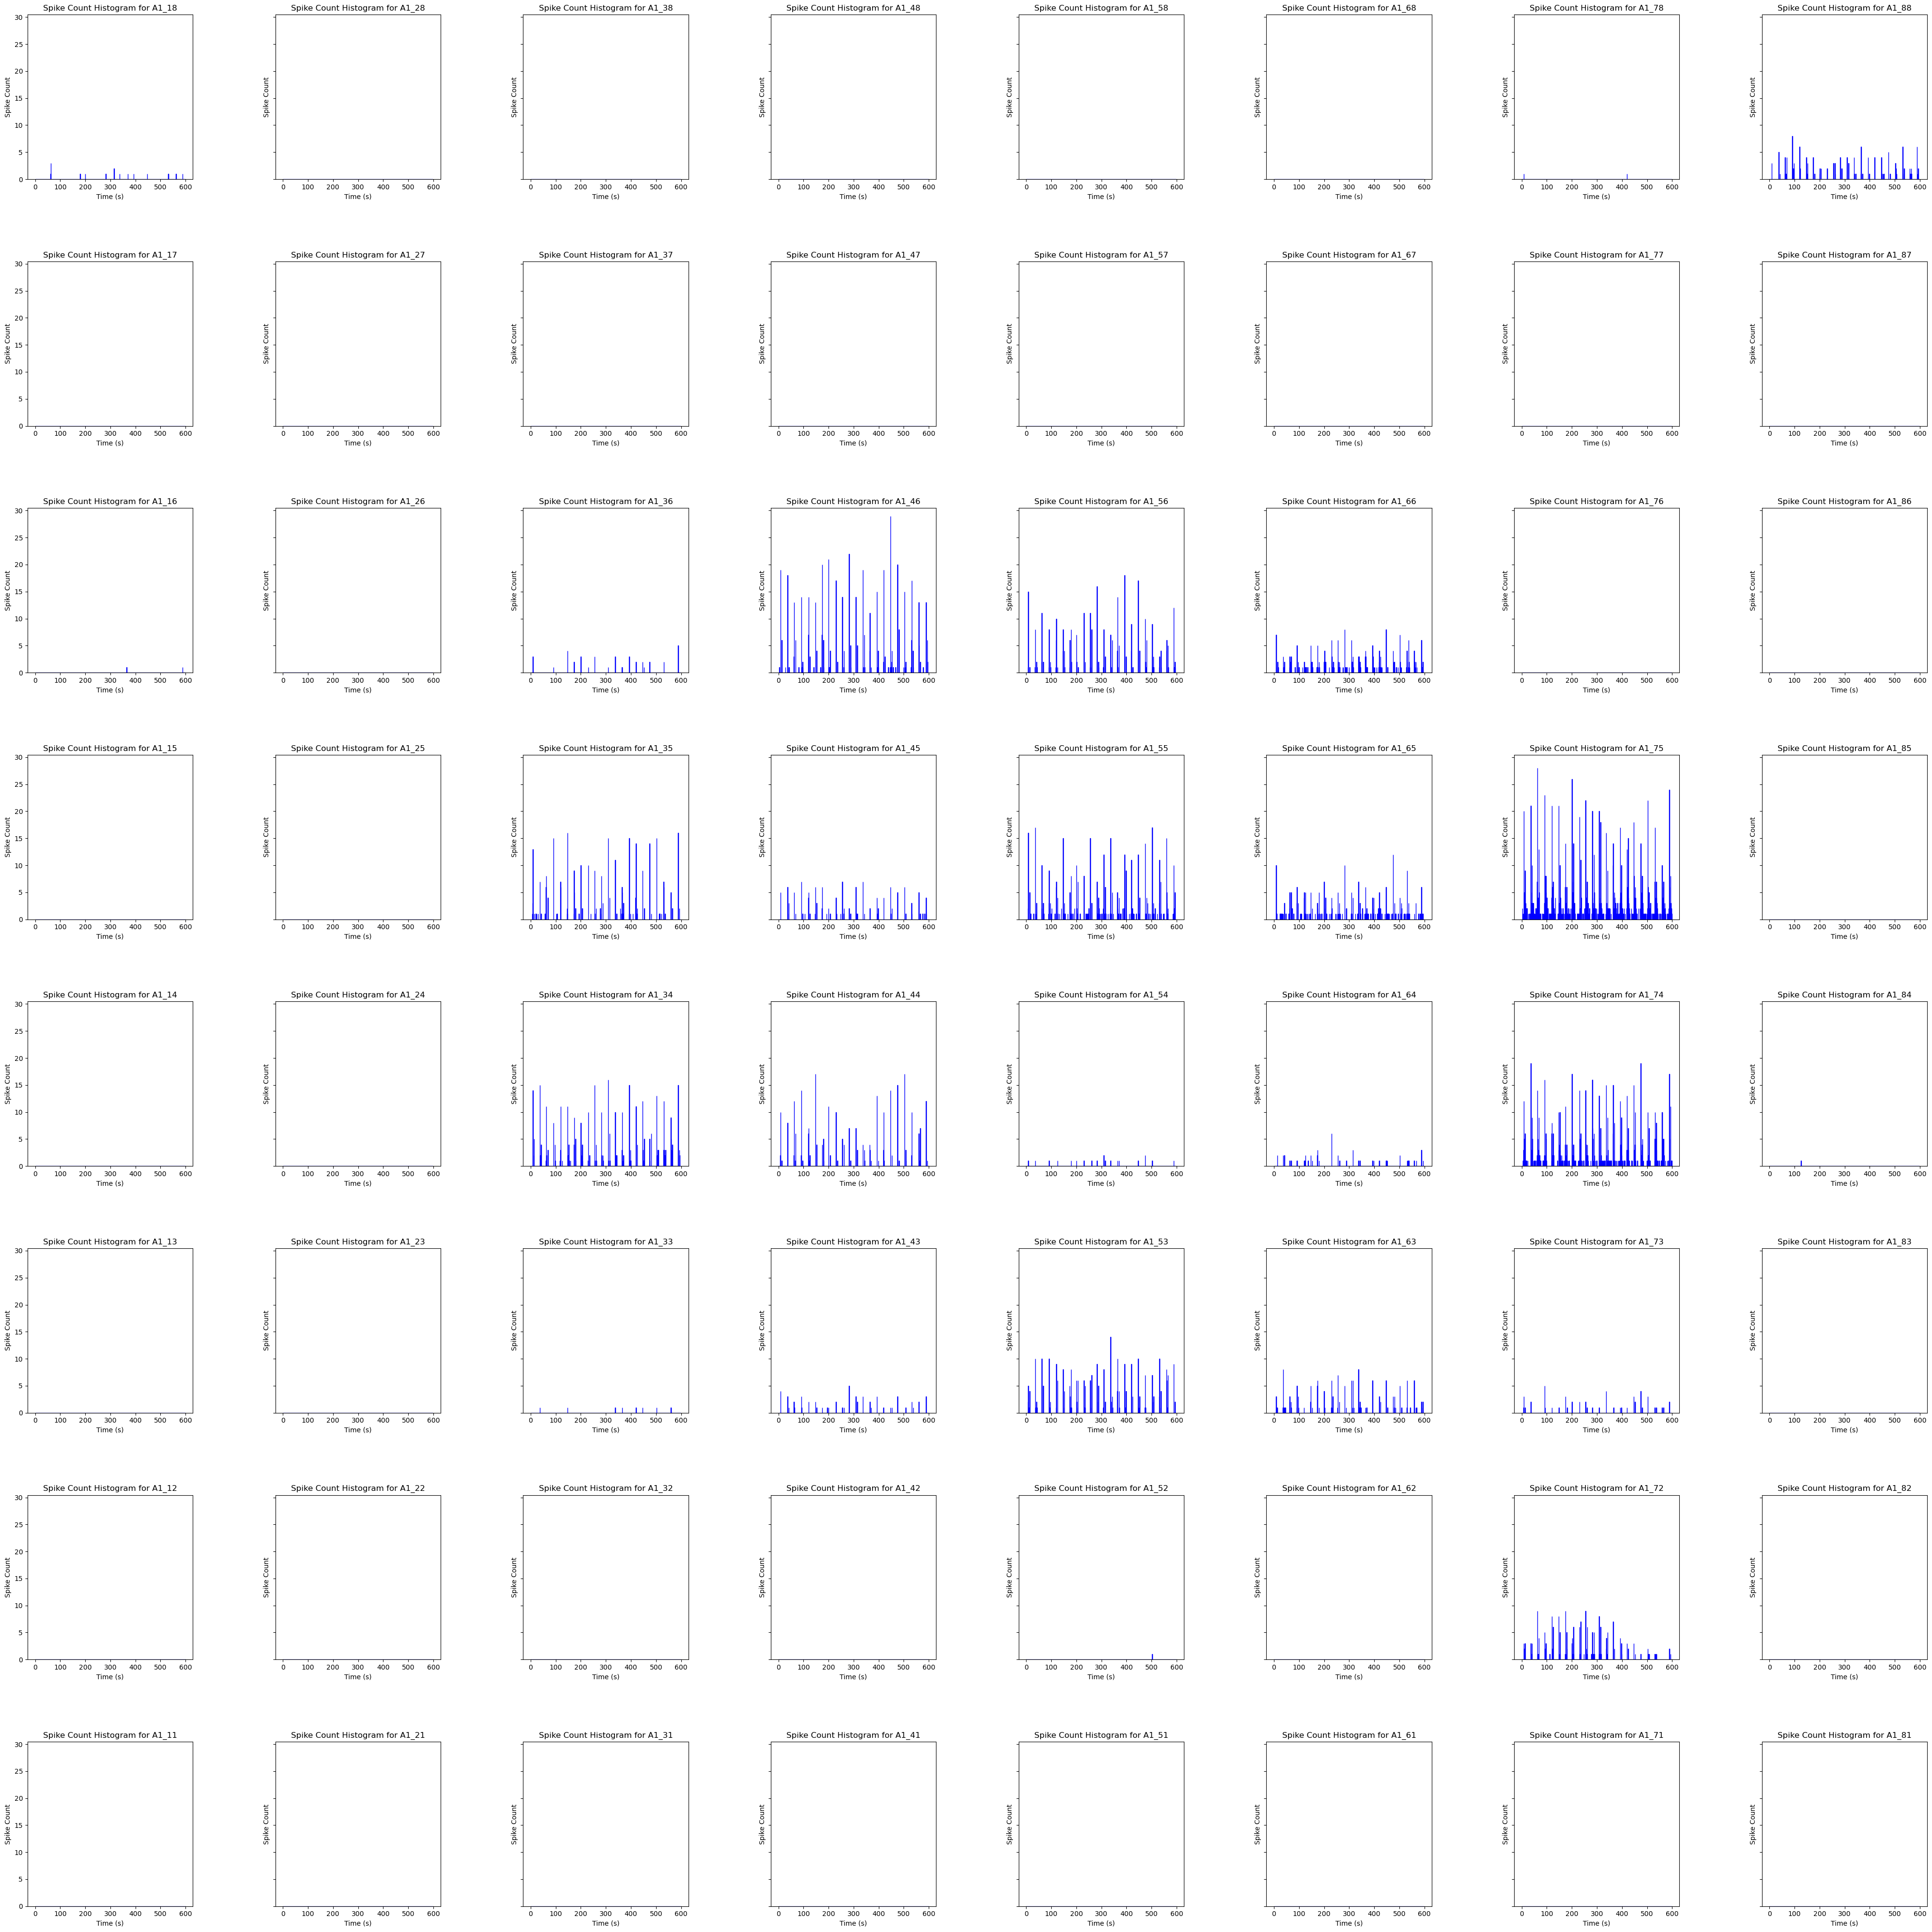

In [9]:
# Create a figure and an array of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5), sharey=True)

# Ensure axs is always an array
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

# Flatten the array of subplots for easy iteration
axs = axs.flatten()

# Loop through each column to process
for index, col in enumerate(columns_to_process, 0):  # had to make this 0 bc it's usually 1
    # Calculate the row and column index for the subplot
    row_idx = num_rows - 1 - (index % num_rows)  # Reverse the row index
    col_idx = index // num_rows

    # Calculate the subplot index
    subplot_index = row_idx * num_cols + col_idx

    # Create a subplot for each column
    ax = axs[subplot_index]
    ax.hist(sorted_bins[col], bins=len(sorted_bins[col]), weights=sorted_counts[col], edgecolor='blue')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Spike Count')
    ax.set_title(f'Spike Count Histogram for {col}')

    # # Add a vertical span (vspan) to highlight a region
    # vspan_start = 1  # Start position of the vertical span
    # vspan_end = 300    # End position of the vertical span
    # ax.axvspan(vspan_start, vspan_end, color='lightgrey', alpha=0.5, zorder = 1)
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Fine-tune the spacing
plt.show()

# Visualizing differences pre- and post-stimulation

## Defining the first and second segment and creating all the Numpy arrays

In [10]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

# Define segment durations
first_segment_duration = 300  # Duration for the first segment
last_segment_duration = 200  # Duration for the last segment
bin_width = 1

# Initialize lists to collect data
all_bins_data = []
all_counts_data = []
first_segment_bins_data = []
first_segment_counts_data = []
last_segment_bins_data = []
last_segment_counts_data = []

# Loop through each column and collect data
for col in columns_to_process:
    bins = sorted_bins[col]
    counts = sorted_counts[col]

    # Calculate segment indices
    first_segment_end_idx = np.searchsorted(bins, first_segment_duration)
    last_segment_start_idx = np.searchsorted(bins, bins[-1] - last_segment_duration + bin_width)

    # Extract segment bins and counts
    first_segment_bins = bins[:first_segment_end_idx]
    first_segment_counts = counts[:first_segment_end_idx]
    last_segment_bins = bins[last_segment_start_idx:]
    last_segment_counts = counts[last_segment_start_idx:]

    # Append data to lists
    all_bins_data.append((col, bins))
    all_counts_data.append((col, counts))
    first_segment_bins_data.append((col, first_segment_bins))
    first_segment_counts_data.append((col, first_segment_counts))
    last_segment_bins_data.append((col, last_segment_bins))
    last_segment_counts_data.append((col, last_segment_counts))

# Define the dtype for the structured arrays
bins_dtype = [('column name', 'U50'), ('bins', 'O')]
counts_dtype = [('column name', 'U50'), ('counts', 'O')]

# Convert lists to structured np.array
structured_bins_array = np.array(all_bins_data, dtype=bins_dtype)
structured_counts_array = np.array(all_counts_data, dtype=counts_dtype)
first_segment_bins_np_array = np.array(first_segment_bins_data, dtype=bins_dtype)
first_segment_counts_np_array = np.array(first_segment_counts_data, dtype=counts_dtype)
last_segment_bins_np_array = np.array(last_segment_bins_data, dtype=bins_dtype)
last_segment_counts_np_array = np.array(last_segment_counts_data, dtype=counts_dtype)

print("structured_bins_array:", structured_bins_array)
print("structured_counts_array:", structured_counts_array)
print("first_segment_bins_np_array:", first_segment_bins_np_array)
print("first_segment_counts_np_array:", first_segment_counts_np_array)
print("last_segment_bins_np_array:", last_segment_bins_np_array)
print("last_segment_counts_np_array:", last_segment_counts_np_array)

structured_bins_array: [('A1_11', list([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0,

## Getting the total duration for the pre- and post-

In [11]:
# Initialize dictionaries to store the total duration
first_segment_total_duration = {}
last_segment_total_duration = {}

# Count the number of bin counts in the first segment and save to dictionary
for value, column_name in enumerate(first_segment_bins_np_array['column name']):
    total_bin_counts = len(first_segment_bins_np_array['bins'][value]) # for every value in the column name, count the number of bins
    first_segment_total_duration[column_name] = total_bin_counts
    print(f"Column: {column_name}, First segment bin counts: {total_bin_counts}")

print("")

# Count the number of bin counts in the last segment and save to dictionary
for value, column_name in enumerate(last_segment_bins_np_array['column name']):
    total_bin_counts = len(last_segment_bins_np_array['bins'][value])
    last_segment_total_duration[column_name] = total_bin_counts
    print(f"Column: {column_name}, Last segment bin counts: {total_bin_counts}")

print("")

# Print the dictionaries
print("First Segment Total Duration:", first_segment_total_duration)
print("Last Segment Total Duration:", last_segment_total_duration)

Column: A1_11, First segment bin counts: 300
Column: A1_12, First segment bin counts: 300
Column: A1_13, First segment bin counts: 300
Column: A1_14, First segment bin counts: 300
Column: A1_15, First segment bin counts: 300
Column: A1_16, First segment bin counts: 300
Column: A1_17, First segment bin counts: 300
Column: A1_18, First segment bin counts: 300
Column: A1_21, First segment bin counts: 300
Column: A1_22, First segment bin counts: 300
Column: A1_23, First segment bin counts: 300
Column: A1_24, First segment bin counts: 300
Column: A1_25, First segment bin counts: 300
Column: A1_26, First segment bin counts: 300
Column: A1_27, First segment bin counts: 300
Column: A1_28, First segment bin counts: 300
Column: A1_31, First segment bin counts: 300
Column: A1_32, First segment bin counts: 300
Column: A1_33, First segment bin counts: 300
Column: A1_34, First segment bin counts: 300
Column: A1_35, First segment bin counts: 300
Column: A1_36, First segment bin counts: 300
Column: A1

## Getting the total spike counts for the pre- and post-

In [12]:
# Initialize dictionaries to store the total spike counts
first_segment_total_spike_counts = {}
last_segment_total_spike_counts = {}

# Count the number of spike counts in the first segment and save to dictionary
for value, column_name in enumerate(first_segment_counts_np_array['column name']):
    total_spike_counts = sum(first_segment_counts_np_array['counts'][value]) # for every value in the column name, add the number of spike counts
    first_segment_total_spike_counts[column_name] = total_spike_counts
    print(f"Column: {column_name}, First segment spike counts: {total_spike_counts}")

print("")

# Count the number of spike counts in the last segment and save to dictionary
for value, column_name in enumerate(last_segment_counts_np_array['column name']):
    total_spike_counts = sum(last_segment_counts_np_array['counts'][value])
    last_segment_total_spike_counts[column_name] = total_spike_counts
    print(f"Column: {column_name}, Last segment spike counts: {total_spike_counts}")

print("")

# Print the dictionaries
print("First Segment Total Spike Counts:", first_segment_total_spike_counts)
print("Last Segment Total Spike Counts:", last_segment_total_spike_counts)

Column: A1_11, First segment spike counts: 0.0
Column: A1_12, First segment spike counts: 0.0
Column: A1_13, First segment spike counts: 0.0
Column: A1_14, First segment spike counts: 0.0
Column: A1_15, First segment spike counts: 0.0
Column: A1_16, First segment spike counts: 0.0
Column: A1_17, First segment spike counts: 0.0
Column: A1_18, First segment spike counts: 7.0
Column: A1_21, First segment spike counts: 0.0
Column: A1_22, First segment spike counts: 0.0
Column: A1_23, First segment spike counts: 0.0
Column: A1_24, First segment spike counts: 0.0
Column: A1_25, First segment spike counts: 0.0
Column: A1_26, First segment spike counts: 0.0
Column: A1_27, First segment spike counts: 0.0
Column: A1_28, First segment spike counts: 0.0
Column: A1_31, First segment spike counts: 0.0
Column: A1_32, First segment spike counts: 0.0
Column: A1_33, First segment spike counts: 2.0
Column: A1_34, First segment spike counts: 198.0
Column: A1_35, First segment spike counts: 165.0
Column: A

## Getting the mean firing rates for the pre- and post-

In [13]:
# Initialize dictionaries to store the mean firing rates
first_segment_mean_firing_rate = {}
last_segment_mean_firing_rate = {}

# Calculate the mean firing rate for the first segment
for column in first_segment_total_spike_counts:
    total_spike_counts = first_segment_total_spike_counts[column]
    total_duration = first_segment_total_duration[column]
    mean_firing_rate = total_spike_counts / total_duration
    first_segment_mean_firing_rate[column] = mean_firing_rate
    print(f"Column: {column}, First segment mean firing rate: {mean_firing_rate}")

print("")

# Calculate the mean firing rate for the last segment
for column in last_segment_total_spike_counts:
    total_spike_counts = last_segment_total_spike_counts[column]
    total_duration = last_segment_total_duration[column]
    mean_firing_rate = total_spike_counts / total_duration
    last_segment_mean_firing_rate[column] = mean_firing_rate
    print(f"Column: {column}, Last segment mean firing rate: {mean_firing_rate}")

print("")

# Print the dictionaries
print("First Segment Mean Firing Rate:", first_segment_mean_firing_rate)
print("Last Segment Mean Firing Rate:", last_segment_mean_firing_rate)

Column: A1_11, First segment mean firing rate: 0.0
Column: A1_12, First segment mean firing rate: 0.0
Column: A1_13, First segment mean firing rate: 0.0
Column: A1_14, First segment mean firing rate: 0.0
Column: A1_15, First segment mean firing rate: 0.0
Column: A1_16, First segment mean firing rate: 0.0
Column: A1_17, First segment mean firing rate: 0.0
Column: A1_18, First segment mean firing rate: 0.023333333333333334
Column: A1_21, First segment mean firing rate: 0.0
Column: A1_22, First segment mean firing rate: 0.0
Column: A1_23, First segment mean firing rate: 0.0
Column: A1_24, First segment mean firing rate: 0.0
Column: A1_25, First segment mean firing rate: 0.0
Column: A1_26, First segment mean firing rate: 0.0
Column: A1_27, First segment mean firing rate: 0.0
Column: A1_28, First segment mean firing rate: 0.0
Column: A1_31, First segment mean firing rate: 0.0
Column: A1_32, First segment mean firing rate: 0.0
Column: A1_33, First segment mean firing rate: 0.0066666666666666

## Testing normality and performing t-test or Mann-Whitney U test

In [14]:
# Perform statistical tests and extract p-values
test_results = []
p_values = {}
for i, col in enumerate(columns_to_process):
    first_segment_counts = first_segment_counts_np_array[i][1]
    last_segment_counts = last_segment_counts_np_array[i][1]
    
    # Perform Shapiro-Wilk test for normality
    first_normal = shapiro(first_segment_counts).pvalue > 0.05
    last_normal = shapiro(last_segment_counts).pvalue > 0.05
    
    if first_normal and last_normal:
        # Perform t-test if both segments are normally distributed
        t_stat, p_value = ttest_ind(first_segment_counts, last_segment_counts)
        test_type = 't-test'
    else:
        # Perform Mann-Whitney U test if either segment is not normally distributed
        t_stat, p_value = mannwhitneyu(first_segment_counts, last_segment_counts)
        test_type = 'Mann-Whitney U test'
    
    # Store results
    test_results.append((col, test_type, t_stat, round(p_value, 3)))
    p_values[col] = p_value

# Print test results
print("Test results for each column:")
for col, test_type, t_stat, p_value in test_results:
    print(f"Column: {col}, Test: {test_type}, Statistic: {t_stat}, P-value: {p_value}")
    

Test results for each column:
Column: A1_11, Test: t-test, Statistic: nan, P-value: nan
Column: A1_12, Test: t-test, Statistic: nan, P-value: nan
Column: A1_13, Test: t-test, Statistic: nan, P-value: nan
Column: A1_14, Test: t-test, Statistic: nan, P-value: nan
Column: A1_15, Test: t-test, Statistic: nan, P-value: nan
Column: A1_16, Test: Mann-Whitney U test, Statistic: 29850.0, P-value: 0.222
Column: A1_17, Test: t-test, Statistic: nan, P-value: nan
Column: A1_18, Test: Mann-Whitney U test, Statistic: 29752.5, P-value: 0.52
Column: A1_21, Test: t-test, Statistic: nan, P-value: nan
Column: A1_22, Test: t-test, Statistic: nan, P-value: nan
Column: A1_23, Test: t-test, Statistic: nan, P-value: nan
Column: A1_24, Test: t-test, Statistic: nan, P-value: nan
Column: A1_25, Test: t-test, Statistic: nan, P-value: nan
Column: A1_26, Test: t-test, Statistic: nan, P-value: nan
Column: A1_27, Test: t-test, Statistic: nan, P-value: nan
Column: A1_28, Test: t-test, Statistic: nan, P-value: nan
Colum

c:\Users\Lindsay\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


## Making the difference plot

#### Getting the differences Numpy array for the heat map 

In [23]:
significance_threshold = 0.05  # Define your significance threshold

# Calculate the differences
differences = {column: first_segment_mean_firing_rate[column] - last_segment_mean_firing_rate[column]
               for column in first_segment_mean_firing_rate}

# Filter the columns and differences based on the significance threshold
significant_columns = [col for col in differences if p_values[col] < significance_threshold]
significant_differences = {col: differences[col] for col in significant_columns}
significant_p_values = {col: p_values[col] for col in significant_columns}

# Convert the differences to a numpy array for heatmap
columns = list(differences.keys())
differences_array = np.array(list(differences.values()))

#### Getting the shape of the difference plot to line up with the MEA grid

In [22]:
# Determine the size of the reshaped array
num_columns = len(columns)
side_length = int(np.ceil(np.sqrt(num_columns)))

# Pad the arrays to make them square if necessary
pad_size = side_length**2 - num_columns
differences_array_padded = np.pad(differences_array, (0, pad_size), mode='constant', constant_values=0)
columns_array_padded = np.pad(columns, (0, pad_size), mode='constant', constant_values='')
p_values_array_padded = np.pad([p_values.get(col, np.nan) for col in columns], (0, pad_size), mode='constant', constant_values=np.nan)

# Reshape the arrays to the determined size
difference_matrix = differences_array_padded.reshape(side_length, side_length)
columns_matrix = columns_array_padded.reshape(side_length, side_length)
p_values_matrix = p_values_array_padded.reshape(side_length, side_length)

# Transpose the matrices to count upwards
difference_matrix = difference_matrix.T
columns_matrix = columns_matrix.T
p_values_matrix = p_values_matrix.T

# Flip the matrices vertically to start from the bottom-left corner
difference_matrix = np.flipud(difference_matrix)
columns_matrix = np.flipud(columns_matrix)
p_values_matrix = np.flipud(p_values_matrix)

#### Filtering the heat map to only include the differences and the p values that are significant pre- post- stimulation

In [24]:
# Create an annotation array with column names, differences, and p-values for significant columns only
annot_array = np.array([
    [
        f'{columns_matrix[i, j]}\n{difference_matrix[i, j]:.2f}\np={p_values_matrix[i, j]:.3f}' if p_values_matrix[i, j] < significance_threshold else f'{columns_matrix[i, j]}'
        for j in range(side_length)
    ]
    for i in range(side_length)
])

#### Generating the difference plot heat map

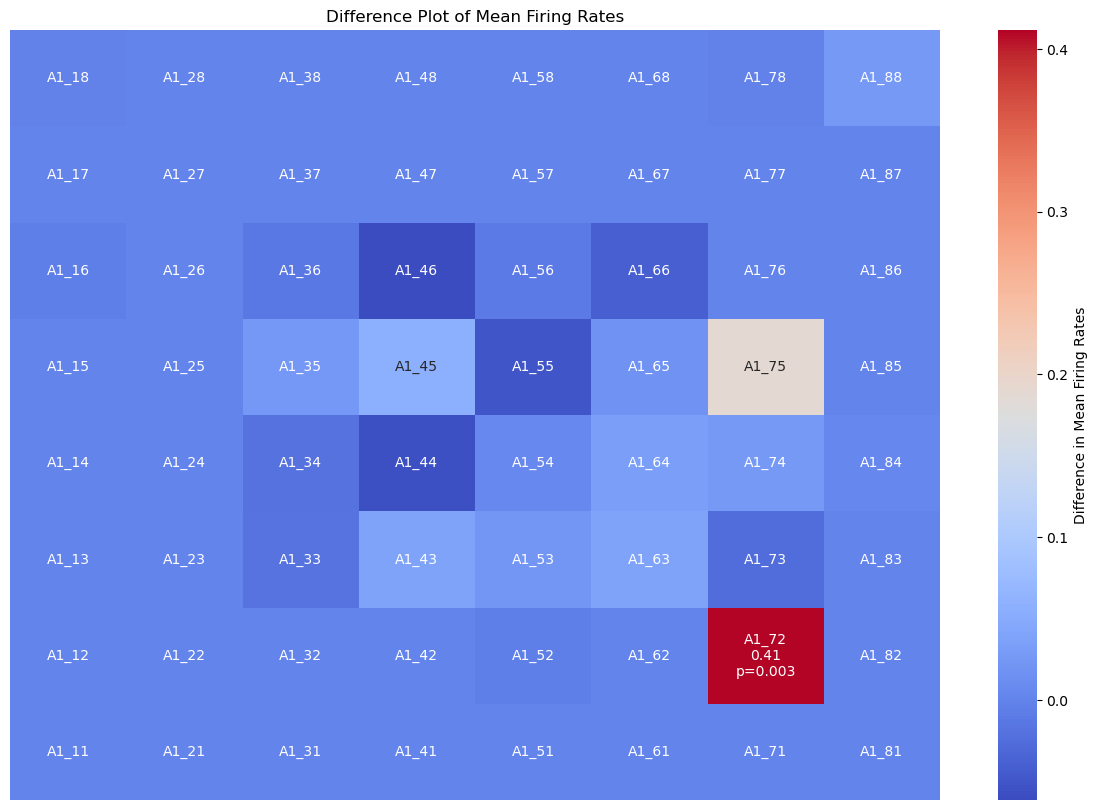

In [25]:
# Create a heat map with a color bar
plt.figure(figsize=(15, 10))  # Adjust the size to fit the grid
ax = sns.heatmap(difference_matrix, cmap='coolwarm', annot=annot_array, fmt='', xticklabels=False, yticklabels=False, cbar=True)
ax.set_title('Difference Plot of Mean Firing Rates')

# Customize the color bar
cbar = ax.collections[0].colorbar
cbar.set_label('Difference in Mean Firing Rates')

plt.show()